In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('customer_booking.csv', encoding="ISO-8859-1")
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

`customer_booking.csv`


To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking


In [4]:
data['flight_day'].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    'Mon': 1, 
    'Tue': 2, 
    'Wed': 3, 
    'Thu': 4, 
    'Fri': 5, 
    'Sat': 6, 
    'Sun': 7
    }
data['flight_day'] = data['flight_day'].map(mapping)
data['flight_day'].unique()

array([6, 3, 4, 1, 7, 2, 5])

### EDA

In [6]:
data.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


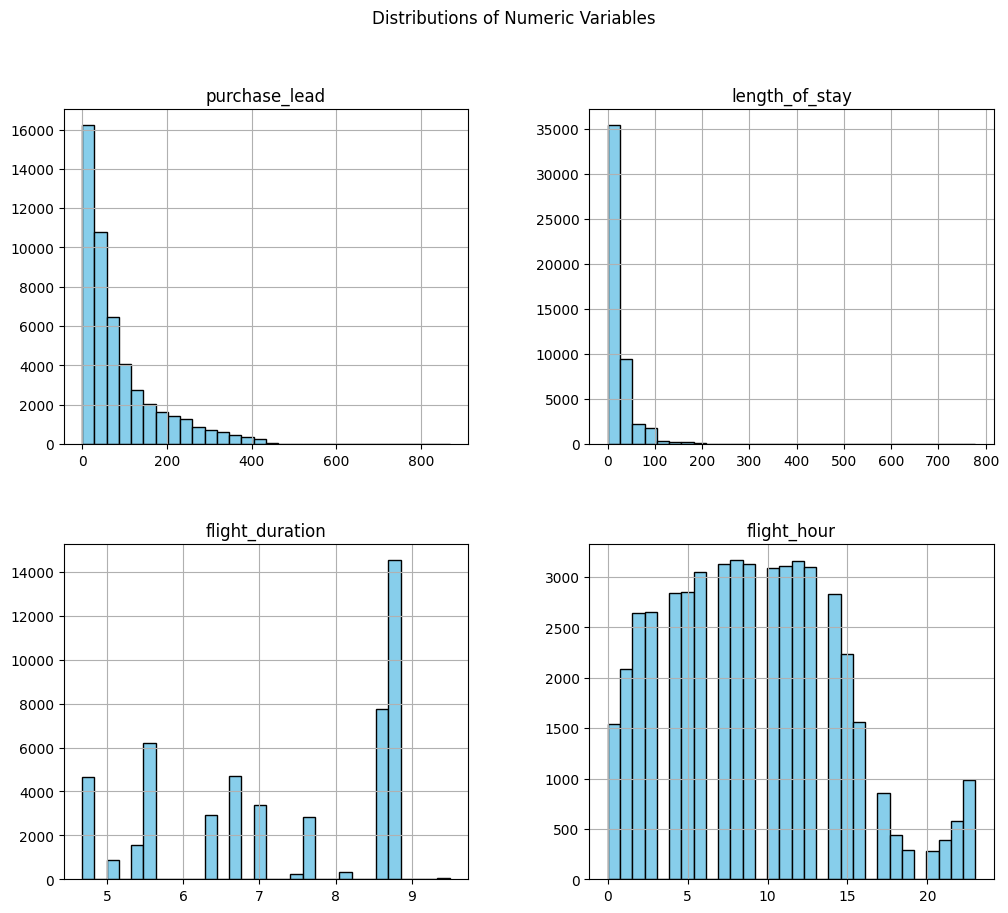

In [7]:
data[['purchase_lead', 'length_of_stay', 'flight_duration', 'flight_hour']].hist(figsize=(12, 10), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Numeric Variables")
plt.show()

> Make a report of the Insights about the numeric variables

### Insights about Numeric Variables1. **purchase_lead**:
   - Ranges between 0 and 867 days.
   - Mean value of ~84.94, indicating customers typically book flights about 85 days before travel.
   - Heavily right-skewed distribution; most bookings occur within 200 days before travel.

2. **length_of_stay**:
   - Ranges between 0 and 778 days.
   - Mean length of stay is ~23.04 days, suggesting most trips are short-term.
   - Strong right skew; majority of customers stay for less than 50 days, with long stays being rare.

3. **flight_hour**:
   - Values range from 0 to 23 (representing hours of a day).
   - Mean flight hour is ~9.07, showing flights are commonly scheduled in the morning hours.
   - Normally distributed, but with a slight increase in numbers around early to mid-morning.

4. **flight_duration**:
   - Values range between 4.67 and 9.5 hours per flight.
   - Mean duration of ~7.28 hours suggests most flights are medium to long-haul.
   - Most flights fall between 5.5 and 8.5 hours duration.

5. **binary features (wants_extra_baggage, wants_preferred_seat, wants_in_flight_meals)**:
   - `wants_extra_baggage`: Majority (~66.88%) of customers want extra baggage.
   - `wants_preferred_seat`: About 29.7% of customers prefer a specific seat.
   - `wants_in_flight_meals`: Around 42.71% of passengers opt for in-flight meals.

6. **booking_complete**:
   - Only ~14.96% (low proportion) of bookings are completed.
   - Highlighting a potentially high rate of abandoned bookings.

7. **Correlations**:
   - `purchase_lead` correlates positively with `length_of_stay`, albeit weakly (~0.26).
   - No strong correlations identified between numeric variables and `booking_complete`. 

In summary, the numeric variables reveal insights into travel planning behaviors, flight trends, and service preferences. Notably, there is a high percentage of incomplete bookings, possibly signaling room for customer experience improvement.

> Analyze the **binary features (wants_extra_baggage, wants_preferred_seat, wants_in_flight_meals)** for yes or no 

In [8]:
# Calculate the proportions of "Yes" (1) and "No" (0) responses for 'wants_extra_baggage'
extra_baggage_count = data['wants_extra_baggage'].value_counts(normalize=True) * 100
extra_baggage_count

wants_extra_baggage
1    66.878
0    33.122
Name: proportion, dtype: float64

In [9]:
# Calculate the proportions of "Yes" (1) and "No" (0) responses for 'wants_preferred_seat'
preferred_seat_count = data['wants_preferred_seat'].value_counts(normalize=True) * 100
preferred_seat_count

wants_preferred_seat
0    70.304
1    29.696
Name: proportion, dtype: float64

In [10]:
# Calculate the proportions of "Yes" (1) and "No" (0) responses for 'wants_in_flight_meals'
in_flight_meals_count = data['wants_in_flight_meals'].value_counts(normalize=True) * 100
in_flight_meals_count

wants_in_flight_meals
0    57.286
1    42.714
Name: proportion, dtype: float64

In [11]:
# Summarizing the binary feature analysis in a DataFrame
binary_feature_analysis = pd.DataFrame({
    'Feature': ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals'],
    'Yes (%)': [extra_baggage_count[1], preferred_seat_count[1], in_flight_meals_count[1]],
    'No (%)': [extra_baggage_count[0], preferred_seat_count[0], in_flight_meals_count[0]]
})
binary_feature_analysis

,Feature,Yes (%),No (%)
0,wants_extra_baggage,66.878,33.122
1,wants_preferred_seat,29.696,70.304
2,wants_in_flight_meals,42.714,57.286


> Make a vizualization for the summary above

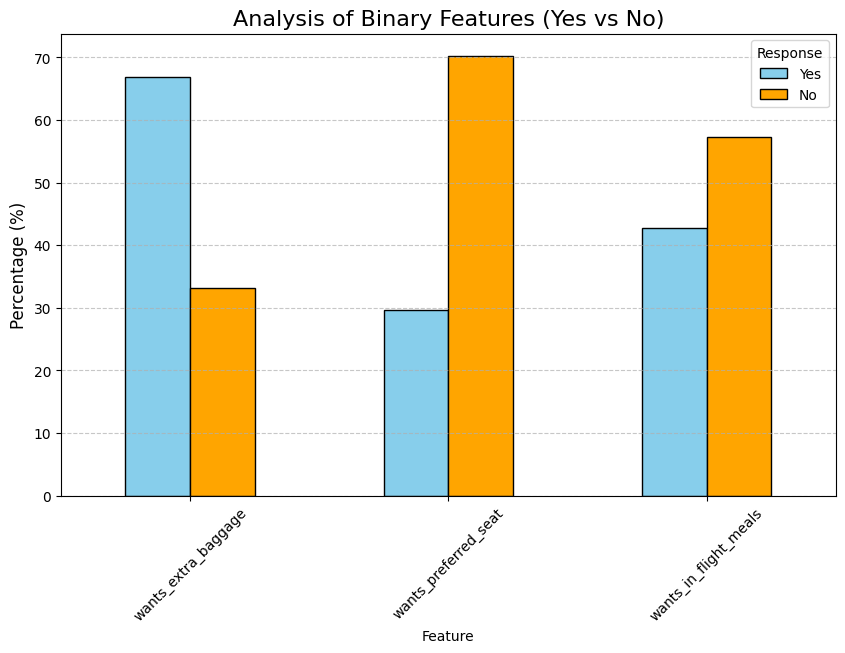

In [12]:
# Plotting the summary of binary features
binary_feature_analysis.set_index('Feature').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black')
plt.title('Analysis of Binary Features (Yes vs No)', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Response', labels=['Yes', 'No'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

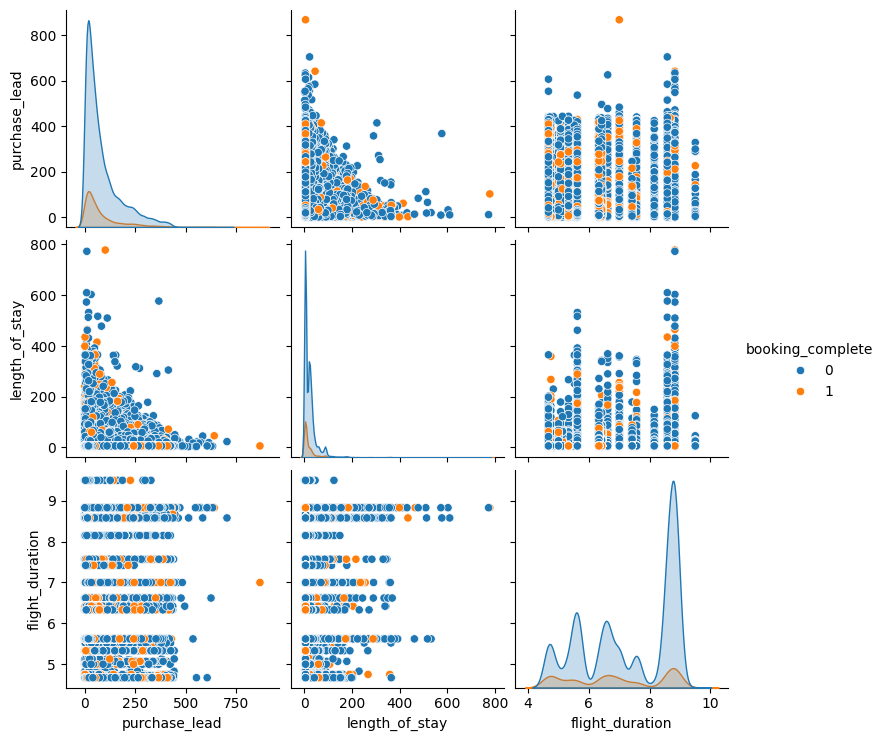

In [13]:
sns.pairplot(data[['purchase_lead', 'length_of_stay', 'flight_duration', 'booking_complete']], hue='booking_complete')
plt.show()

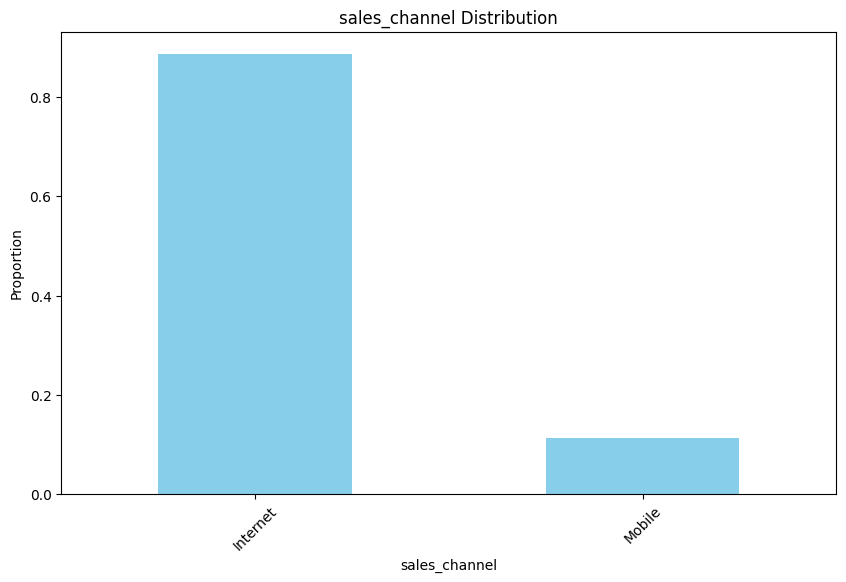

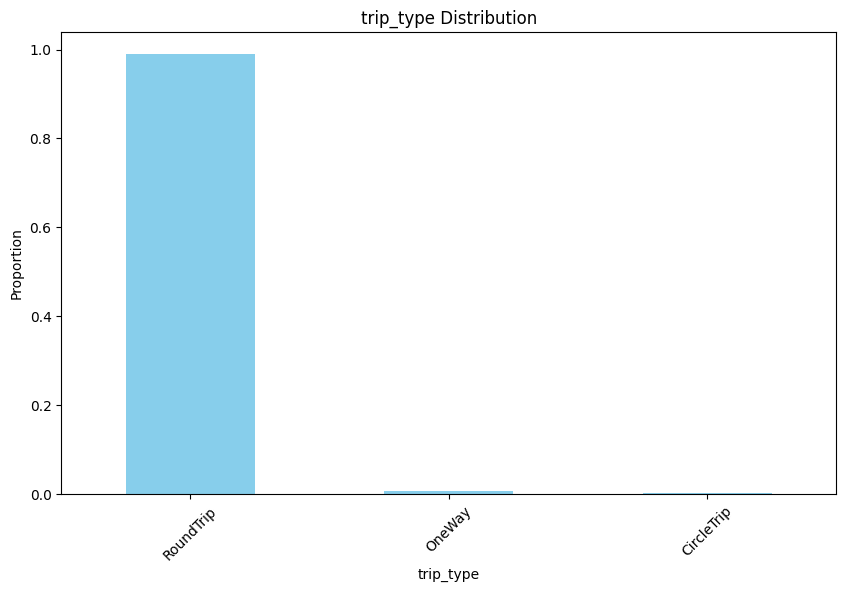

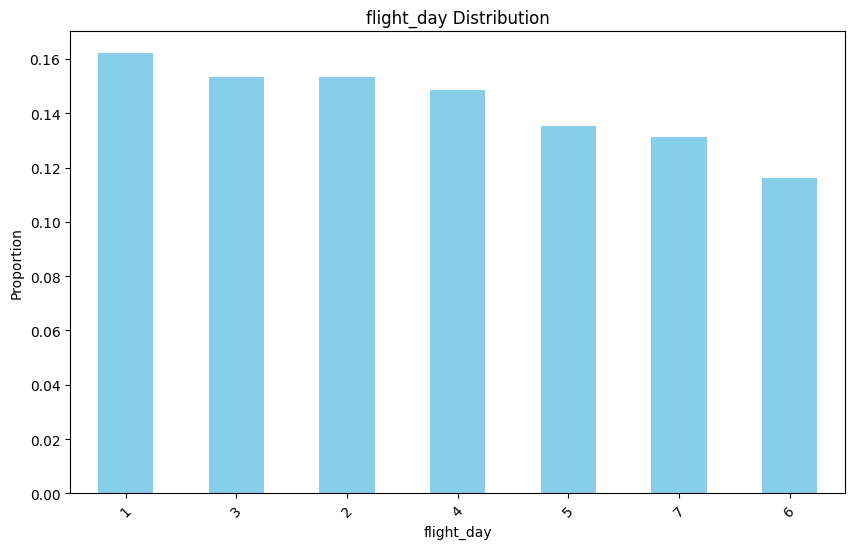

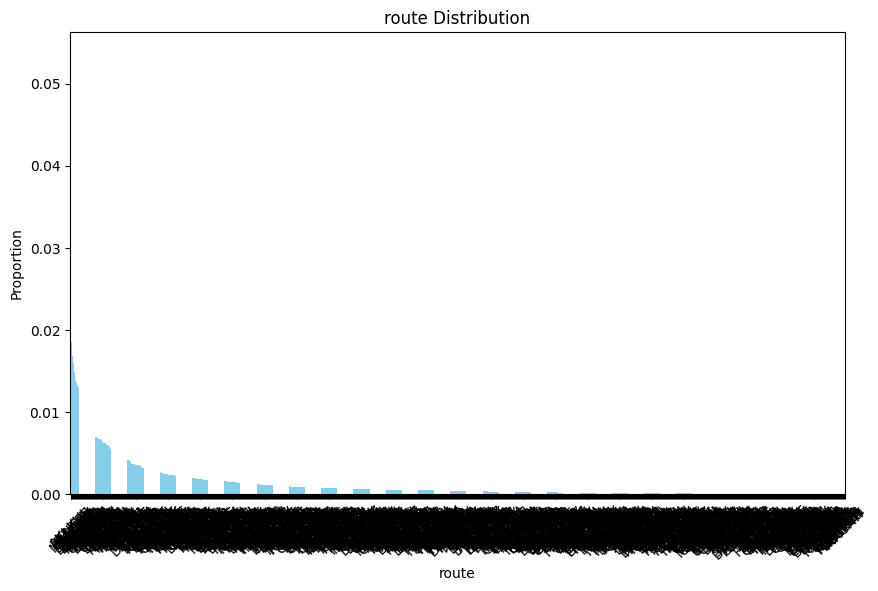

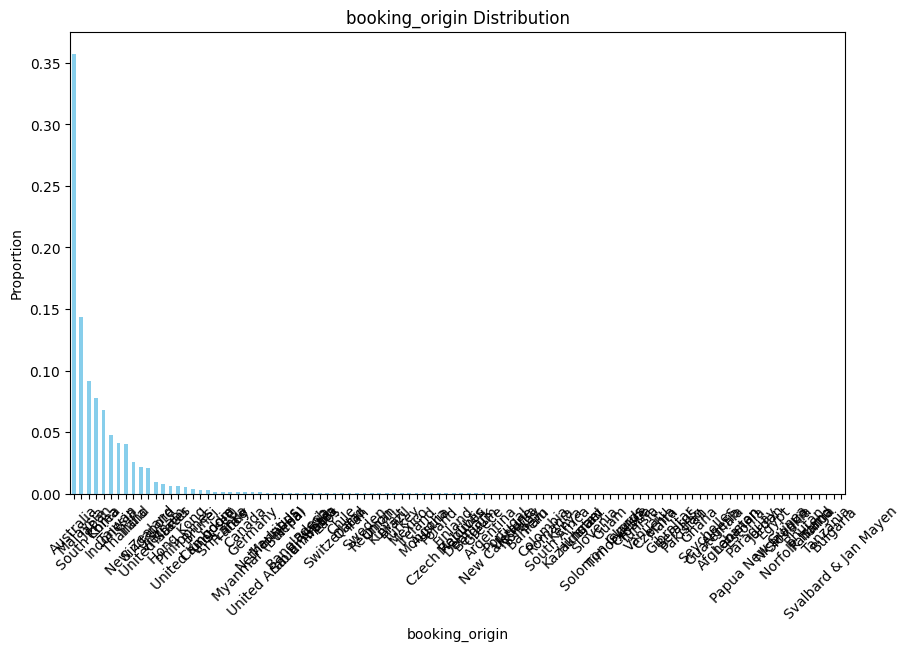

In [14]:
# Plot distributions of all categorical variables
categorical_columns = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    data[col].value_counts(normalize=True).plot(kind='bar', color='skyblue', title=f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.show()

> Make a report of the Insights about the categorical variables

### Insights about Categorical Variables

In [15]:
# Analyze `sales_channel`
sales_channel_proportions = data['sales_channel'].value_counts(normalize=True) * 100
sales_channel_proportions

sales_channel
Internet    88.764
Mobile      11.236
Name: proportion, dtype: float64

In [16]:
# Analyze `trip_type`
trip_type_proportions = data['trip_type'].value_counts(normalize=True) * 100
trip_type_proportions

trip_type
RoundTrip     98.994
OneWay         0.774
CircleTrip     0.232
Name: proportion, dtype: float64

In [17]:
# Analyze `flight_day`
flight_day_proportions = data['flight_day'].value_counts(normalize=True).sort_index() * 100
flight_day_proportions

flight_day
1    16.204
2    15.346
3    15.348
4    14.848
5    13.522
6    11.624
7    13.108
Name: proportion, dtype: float64

In [18]:
# Analyze `route`
route_top10 = data['route'].value_counts(normalize=True).head(10) * 100  # Top 10 routes
route_top10

route
AKLKUL    5.360
PENTPE    1.848
MELSGN    1.684
ICNSIN    1.602
DMKKIX    1.488
ICNSYD    1.390
DMKPER    1.358
DPSICN    1.332
DMKOOL    1.310
MELPEN    1.298
Name: proportion, dtype: float64

In [19]:
# Analyze `booking_origin`
booking_origin_top10 = data['booking_origin'].value_counts(normalize=True).head(10) * 100  # Top 10 origins
booking_origin_top10

booking_origin
Australia      35.744
Malaysia       14.348
South Korea     9.118
Japan           7.770
China           6.774
Indonesia       4.738
Taiwan          4.154
Thailand        4.060
India           2.540
New Zealand     2.148
Name: proportion, dtype: float64

In [20]:
# Summary Report of Insights:
categorical_insights = {
    'sales_channel': sales_channel_proportions.to_dict(),
    'trip_type': trip_type_proportions.to_dict(),
    'flight_day': flight_day_proportions.to_dict(),
    'route_top10': route_top10.to_dict(),
    'booking_origin_top10': booking_origin_top10.to_dict()
}
categorical_insights

{'sales_channel': {'Internet': 88.764, 'Mobile': 11.236},
 'trip_type': {'RoundTrip': 98.994, 'OneWay': 0.774, 'CircleTrip': 0.232},
 'flight_day': {1: 16.204,
  2: 15.346000000000002,
  3: 15.348,
  4: 14.848,
  5: 13.522,
  6: 11.623999999999999,
  7: 13.108},
 'route_top10': {'AKLKUL': 5.36,
  'PENTPE': 1.848,
  'MELSGN': 1.6840000000000002,
  'ICNSIN': 1.6019999999999999,
  'DMKKIX': 1.488,
  'ICNSYD': 1.39,
  'DMKPER': 1.358,
  'DPSICN': 1.332,
  'DMKOOL': 1.31,
  'MELPEN': 1.298},
 'booking_origin_top10': {'Australia': 35.744,
  'Malaysia': 14.347999999999999,
  'South Korea': 9.118,
  'Japan': 7.7700000000000005,
  'China': 6.773999999999999,
  'Indonesia': 4.7379999999999995,
  'Taiwan': 4.154,
  'Thailand': 4.06,
  'India': 2.54,
  'New Zealand': 2.1479999999999997}}

> Make a writing report of the Insights about the categorical variables

### Insights about Categorical Variables1. **Sales Channel**:
   - The majority of bookings (88.76%) occur through the Internet.
   - Mobile sales channels account for only 11.24% of total bookings, indicating that users primarily prefer desktop/web platforms for making bookings.

2. **Trip Type**:
   - Round trips dominate the bookings, accounting for 98.99% of the data.
   - One-way and circle trips are rare, contributing only 0.77% and 0.23% respectively.

3. **Flight Day**:
   - Bookings are relatively evenly distributed across the week, but:
     - Mondays (16.20%) are the most popular day for flights.
     - Saturdays (11.62%) see the least demand.
   - There is no significant clustering of preferences on a specific day.

4. **Route**:
   - The top 10 flight routes (by proportion) collectively make up around 18% of the total data.
   - The most popular route is `AKLKUL` with 5.36% of bookings.
   - All other top routes (e.g., `PENTPE`, `MELSGN`, `ICNSIN`) have a relatively low share, ranging between 1% and 1.8%.

5. **Booking Origin**:
   - Users from Australia dominate the bookings, accounting for 35.74% of the origin data.
   - Malaysia (14.35%), South Korea (9.12%), and Japan (7.77%) represent the next largest groups.
   - These top 10 origins constitute a significant majority of bookings, with lesser representation from countries like India (2.54%) and New Zealand (2.15%).

In summary, most bookings come from Internet platforms for round trips originating in countries like Australia or Malaysia. Flight preferences are consistent across weekdays, and specific routes and origin countries show strong trends in customer preferences.

In [21]:
data['booking_complete'].value_counts(normalize=True)

booking_complete
0    0.85044
1    0.14956
Name: proportion, dtype: float64

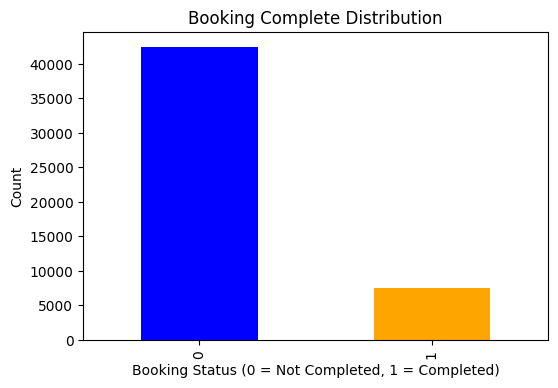

In [22]:
data['booking_complete'].value_counts().plot(kind='bar', figsize=(6,4), color=['blue', 'orange'], title="Booking Complete Distribution")
plt.xlabel('Booking Status (0 = Not Completed, 1 = Completed)')
plt.ylabel('Count')
plt.show()

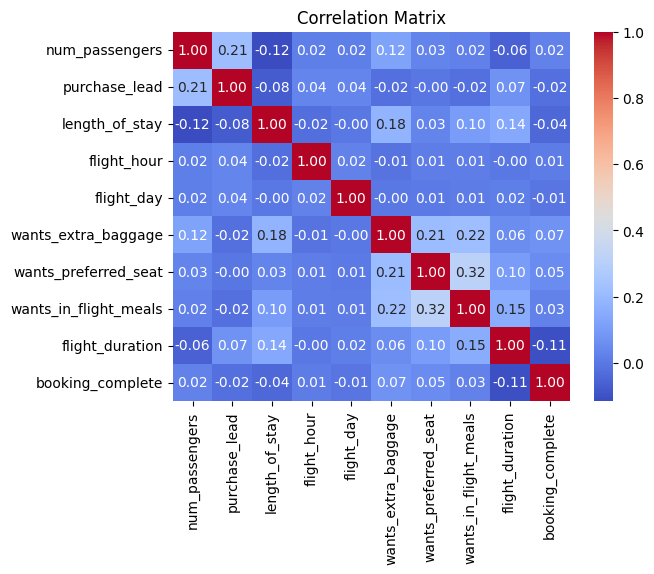

In [23]:
numeric_data = data.select_dtypes(include=[np.number])
correlations = numeric_data.corr()
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

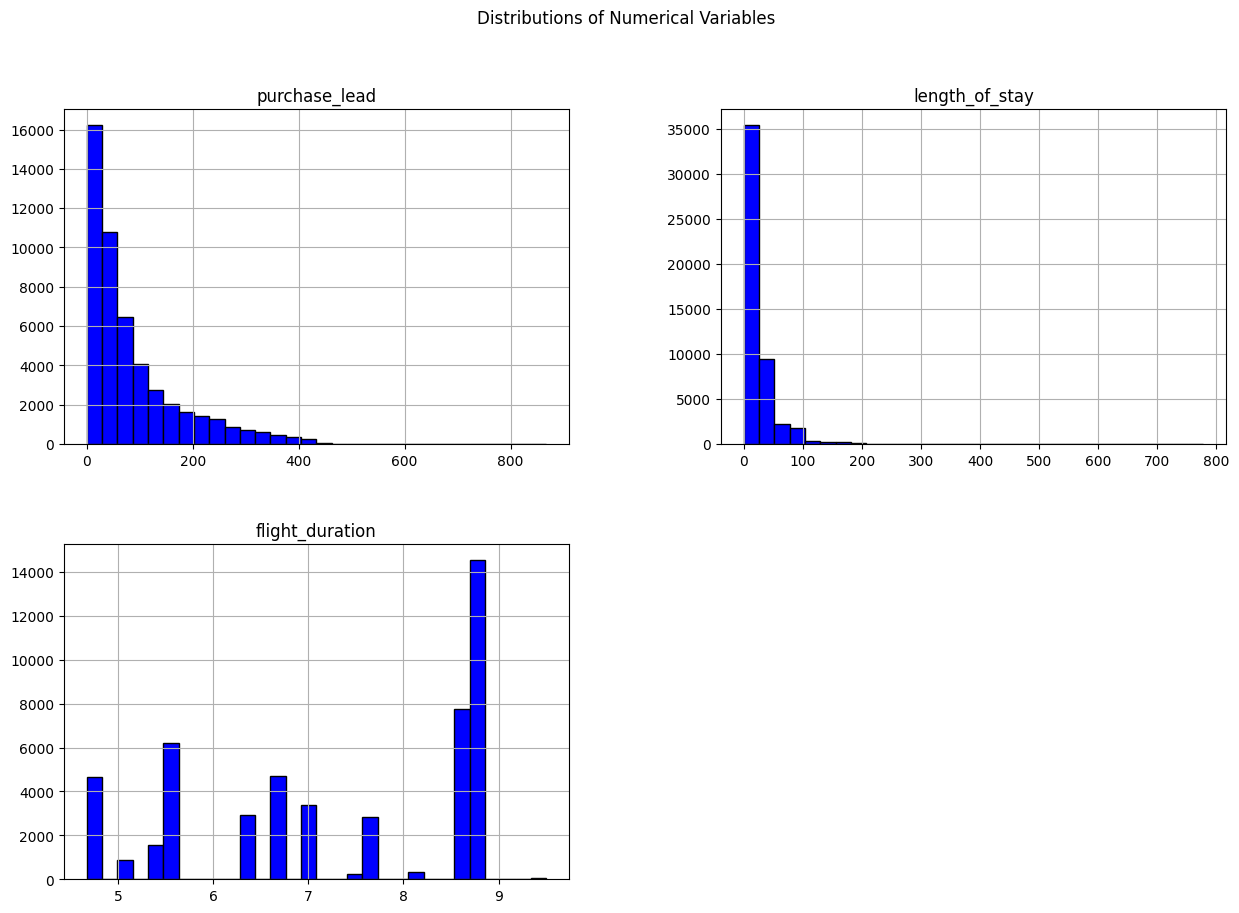

In [24]:
data[['purchase_lead', 'length_of_stay', 'flight_duration']].hist(figsize=(15, 10), bins=30, color='blue', edgecolor='black')
plt.suptitle("Distributions of Numerical Variables")
plt.show()

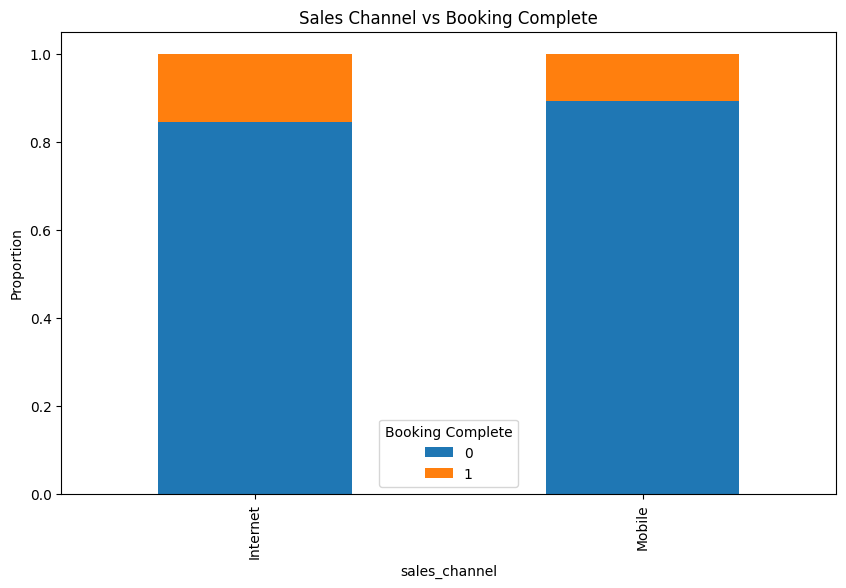

In [25]:
pd.crosstab(data['sales_channel'], data['booking_complete'], normalize='index').plot(kind='bar', stacked=True, figsize=(10, 6), title="Sales Channel vs Booking Complete")
plt.ylabel("Proportion")
plt.legend(title="Booking Complete", loc='best')
plt.show()

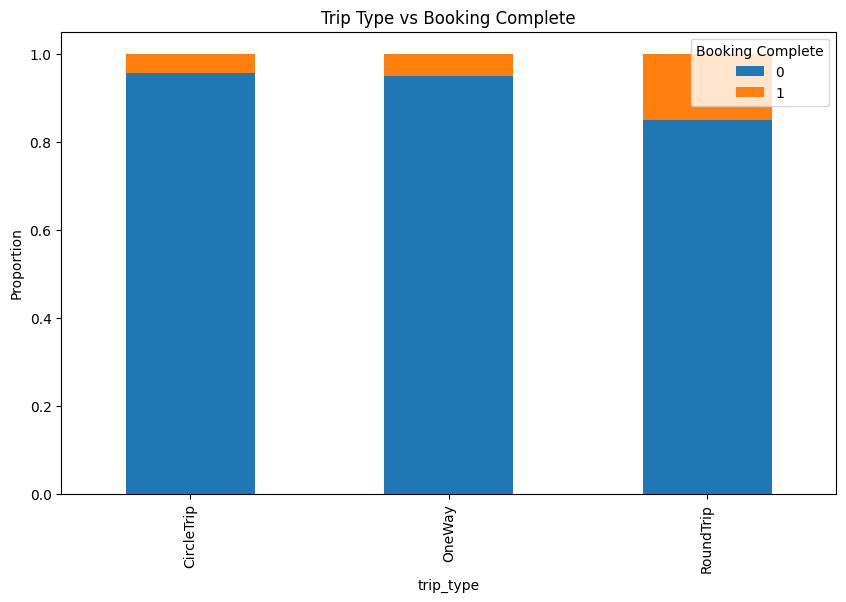

In [26]:
pd.crosstab(data['trip_type'], data['booking_complete'], normalize='index').plot(kind='bar', stacked=True, figsize=(10, 6), title="Trip Type vs Booking Complete")
plt.ylabel("Proportion")
plt.legend(title="Booking Complete", loc='best')
plt.show()

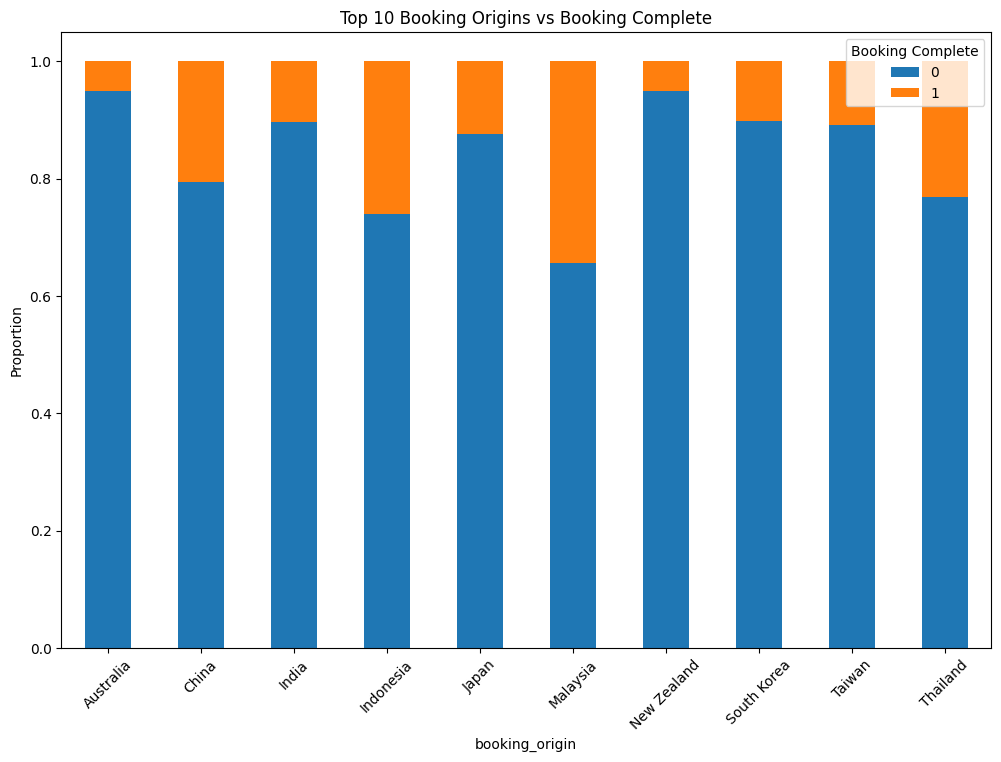

In [27]:
top_countries = data['booking_origin'].value_counts().head(10).index
filtered_data = data[data['booking_origin'].isin(top_countries)]
pd.crosstab(filtered_data['booking_origin'], filtered_data['booking_complete'], normalize='index').plot(kind='bar', stacked=True, figsize=(12, 8), title="Top 10 Booking Origins vs Booking Complete")
plt.ylabel("Proportion")
plt.legend(title="Booking Complete")
plt.xticks(rotation=45)
plt.show()

In [28]:
top_routes = data['route'].value_counts().head(10).index
top_routes_data = data[data['route'].isin(top_routes)]
top_routes_data['route'].value_counts()

route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
ICNSYD     695
DMKPER     679
DPSICN     666
DMKOOL     655
MELPEN     649
Name: count, dtype: int64

Analyze the relationship between the top 10 routes and booking completion.

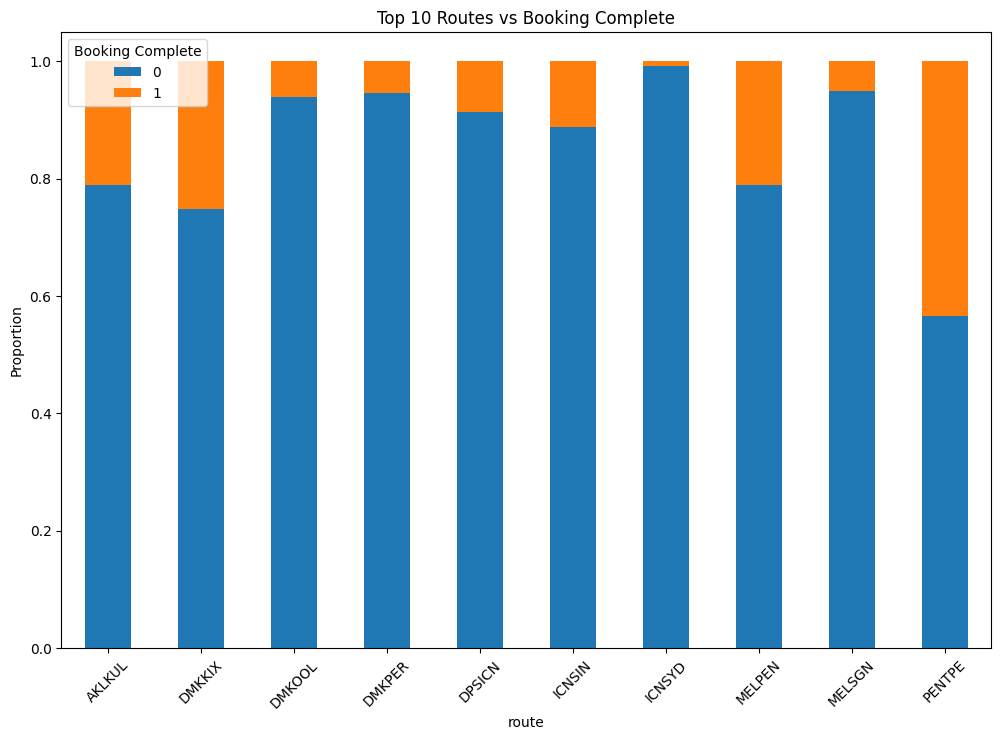

In [29]:
pd.crosstab(top_routes_data['route'], top_routes_data['booking_complete'], normalize='index').plot(kind='bar', stacked=True, figsize=(12, 8), title="Top 10 Routes vs Booking Complete")
plt.ylabel("Proportion")
plt.legend(title="Booking Complete")
plt.xticks(rotation=45)
plt.show()

## Modelo ML

### 1. Encoding
Performed one-hot encoding on categorical features such as `sales_channel`, `trip_type`, `route`, and `booking_origin` to convert them into a machine-readable format.

In [52]:
# Selecting relevant features
selected_features = [
    'num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
    'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin',
    'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
    'flight_duration'
]

X = data[selected_features]
y = data['booking_complete']

# One-hot encoding for categorical variables
X_encoded = pd.get_dummies(X, columns=['sales_channel', 'trip_type', 'route', 'booking_origin'], drop_first=True)

X_encoded.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,sales_channel_Mobile,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,2,262,19,7,6,1,0,0,5.52,False,...,False,False,False,False,False,False,False,False,False,False
1,1,112,20,3,6,0,0,0,5.52,False,...,False,False,False,False,False,False,False,False,False,False
2,2,243,22,17,3,1,1,0,5.52,False,...,False,False,False,False,False,False,False,False,False,False
3,1,96,31,4,6,0,0,1,5.52,False,...,False,False,False,False,False,False,False,False,False,False
4,2,68,22,15,3,1,0,1,5.52,False,...,False,False,False,False,False,False,False,False,False,False


### 2. Data Splitting
The dataset was divided into training and testing subsets to evaluate the model effectively. A stratified split ensured balanced representation of the target class (`booking_complete`).

In [54]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

### 3. Model Building
We chose Random Forests due to their robustness and ability to handle high-dimensional data efficiently. A Random Forest classifier with 100 trees was created:

In [56]:
# Creating and training the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 4. Model EvaluationThe model was evaluated on the testing data using various metrics:
- **Accuracy:** Measured the percentage of correct predictions.

In [57]:
# Making predictions
y_pred = rf_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8515333333333334

- **Classification Report:** Detailed precision, recall, and F1 score per class.

In [60]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred, target_names=["Not Completed", "Completed"])
print(report)

               precision    recall  f1-score   support

Not Completed       0.87      0.98      0.92     12757
    Completed       0.51      0.13      0.21      2243

     accuracy                           0.85     15000
    macro avg       0.69      0.56      0.56     15000
 weighted avg       0.81      0.85      0.81     15000



- **Confusion Matrix:** Visualized true positives, true negatives, false positives, and false negatives.
  

In [62]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[12476,   281],
       [ 1946,   297]])

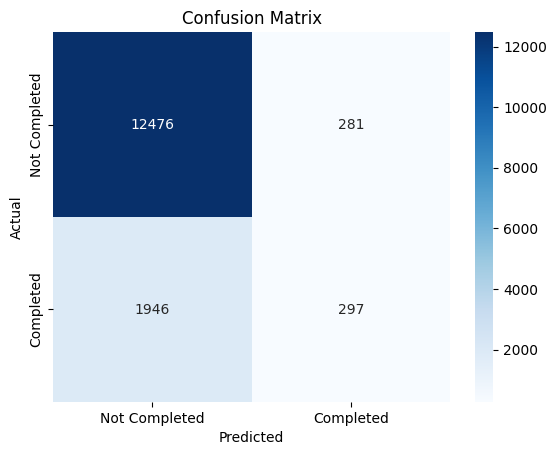

In [64]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Completed", "Completed"], yticklabels=["Not Completed", "Completed"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Findings:**
- Accuracy: 85.15%
- Precision for "Completed" bookings: 51%
- Recall for "Completed" bookings: 13%
- Significant imbalance: The model is more effective at predicting "Not Completed" bookings.

### 5. Feature ImportanceFeature importance was derived to identify the key predictors of booking completion. Significant predictors:
1. `purchase_lead` (advance booking days)
2. `flight_hour` (time of day)
3. `length_of_stay`
4. `flight_day` (day of week)
5. `booking_origin`

These insights can help focus on strategies to increase booking completions:

In [58]:
# Feature importance
feature_importances = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(10)
feature_importances

,Feature,Importance
1,purchase_lead,0.155520
3,flight_hour,0.124884
2,length_of_stay,0.114815
4,flight_day,0.089880
0,num_passengers,0.048483
8,flight_duration,0.035105
860,booking_origin_Malaysia,0.029381
7,wants_in_flight_meals,0.022887
813,booking_origin_Australia,0.018760
6,wants_preferred_seat,0.018760


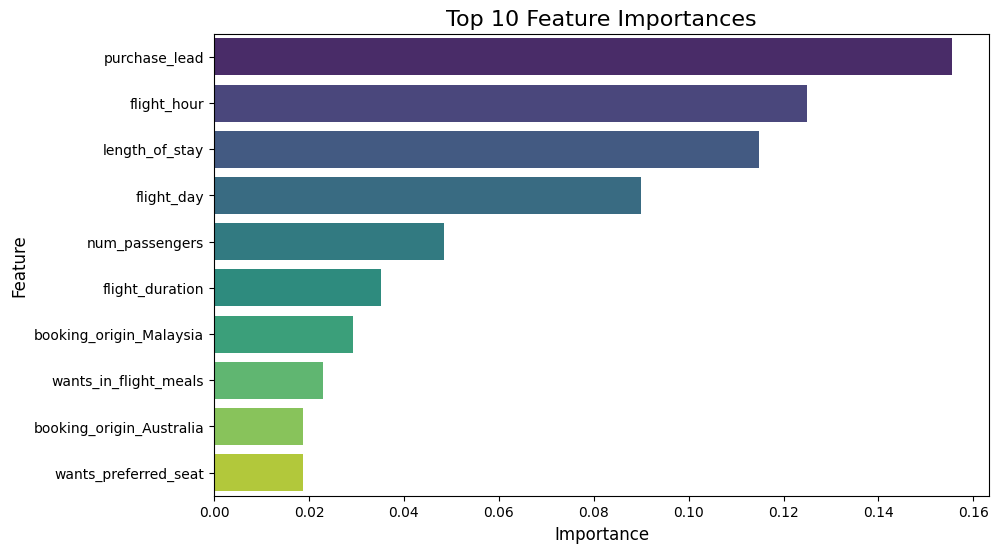

In [74]:
# Plotting the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis', hue = 'Feature', legend = False)
plt.title("Top 10 Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.show()


## Limitations and Observations
1. **Class Imbalance:** Only 14.96% of the bookings were completed. SMOTE or oversampling might improve recall.
2. **Model Bias:** The classifier performs exceedingly well on the majority class ("Not Completed"), leaving room for improvement in identifying completed bookings.
3. **Limited Context:** Some categorical variables, like `route` and `booking_origin`, may benefit from grouping or feature engineering to reduce sparsity.

---

## Conclusion
The Random Forest classifier achieved an overall accuracy of 85%. However, its performance in predicting completed bookings requires improvement. Features such as advance booking days, timing, and customer origin were critical in influencing booking behavior. Further iterations with balancing techniques (e.g., class weighting) and model tuning are recommended to enhance predictability for completed bookings. This analysis provides actionable insights into customer preferences and booking trends, which airlines and travel platforms can leverage for strategic decision-making.